# generate_obs_hte_26_rich()


The `generate_obs_hte_26_rich()` function provides a more complex and realistic observational dataset. It features 11 confounders, complex dependencies (including derived features), a low treatment rate, and a **Tweedie (zero-inflated Gamma)** outcome model.


#### 1. Confounders ($X$)
The dataset contains 11 confounders $X = (X_1, \dots, X_{11})^T$:
- $X_1$: `tenure_months`
- $X_2$: `avg_sessions_week`
- $X_3$: `spend_last_month`
- $X_4$: `age_years`
- $X_5$: `income_monthly`
- $X_6$: `prior_purchases_12m`
- $X_7$: `support_tickets_90d`
- $X_8$: `premium_user`
- $X_9$: `mobile_user`
- $X_{10}$: `urban_resident`
- $X_{11}$: `referred_user`

**Base Features Sampling:**
The base features $(X_1, X_2, X_3, X_4, X_5, X_{10})$ are sampled using a **Gaussian Copula** with the following correlation matrix:

$$\Sigma = \begin{pmatrix}
1.00 & 0.20 & 0.20 & 0.30 & 0.20 & 0.00 \\
0.20 & 1.00 & 0.45 & -0.20 & 0.30 & 0.10 \\
0.20 & 0.45 & 1.00 & -0.10 & 0.40 & 0.10 \\
0.30 & -0.20 & -0.10 & 1.00 & 0.20 & -0.10 \\
0.20 & 0.30 & 0.40 & 0.20 & 1.00 & 0.10 \\
0.00 & 0.10 & 0.10 & -0.10 & 0.10 & 1.00
\end{pmatrix}$$

**Derived Features:**
The remaining features are derived to mimic real-world behavioral dependencies:
- **Premium User ($X_8$):** $\text{logit}(P(X_8=1)) = -5.0 + 0.7 \ln(1+X_2) + 0.45 \ln(1+X_3) + 0.35 \ln(1+X_5) + 0.015 X_1$
- **Mobile User ($X_9$):** $\text{logit}(P(X_9=1)) = 1.5 - 0.03(X_4 - 35) + 0.30 X_{10} + 0.25 \ln(1+X_2)$
- **Referred User ($X_{11}$):** $\text{logit}(P(X_{11}=1)) = -1.2 - 0.02(X_1 - 12) + 0.45 X_9 + 0.20 X_{10}$
- **Prior Purchases ($X_6$):** $X_6 \sim \text{Poisson}(\lambda = \text{clip}(1.0 + 0.55 \ln(1+X_2) + 0.45 \ln(1+X_3) + 0.25 X_8, 0.1, 30.0))$
- **Support Tickets ($X_7$):** $X_7 \sim \text{Poisson}(\lambda = \text{clip}(0.6 + 0.25 \ln(1+X_2) + 0.30(1-X_8) + 0.15 \tanh(\frac{X_4 - 45}{12}), 0.05, 10.0))$

#### 2. Treatment Assignment ($D$)
The treatment $D \in \{0, 1\}$ is assigned with a target rate of **5%**:
$$P(D=1|X) = \sigma\left( \alpha_d + \text{bound}\left( f_d(X), 2.0 \right) \right)$$
where $f_d(X) = \sum_{j=1}^{11} \beta_{d,j} X_j + g_d(X)$ with
$$\beta_d = (-0.004,\ 0,\ 0,\ -0.012,\ -0.00005,\ -0.04,\ 0.22,\ -0.45,\ -0.08,\ -0.12,\ 0.10),$$
and
$$\begin{aligned}
g_d(X) &= -0.55\tanh\!\left(\ln\frac{1+X_3}{61}\right)
 -0.20\ln\frac{1+X_2}{6}\tanh\!\left(\frac{X_1}{24}-1\right)
 -0.25X_8(X_{10}-0.5)
 -0.20X_9\tanh\!\left(\ln\frac{1+X_2}{4}\right)\\
&\quad +0.30X_{11}\left(1-\tanh\frac{X_1}{36}\right)
 +0.35\tanh\!\left(\ln\frac{1+X_7}{2.5}\right)
 -0.25\tanh\!\left(\frac{\ln(1+X_5)-\ln 4001}{1.3}\right)
 -0.12\tanh\!\left(\frac{X_1}{24}\right)
 -0.10\tanh\!\left(\frac{X_4-45}{12}\right).
\end{aligned}$$
This design induces adverse selection (treated units can have lower observed outcomes than controls even when treatment helps on average).

#### 3. Heterogeneous Treatment Effect ($\tau(X)$)
The treatment effect on the link (log-mean) scale is:
$$\tau(X) = 0.08 + 0.08 \tanh\left(\ln\frac{1+X_2}{6}\right) + 0.11 X_8 + 0.03 X_9 + 0.03 X_{11} - 0.07 \tanh\frac{X_1}{48} - 0.05 \tanh\frac{X_4-40}{15} + 0.03 X_{10} \tanh\left(\ln\frac{1+X_3}{61}\right) - 0.04 \tanh\left(\ln\frac{1+X_7}{2.5}\right)$$
and is clipped to $[0.005, 0.35]$.

Important: this clipping is for $\tau(X)$ on the **link** scale, not for CATE itself.

#### 4. Outcome Model ($Y$)
The outcome follows a **Tweedie (Two-part Hurdle)** model:
1. **Zero-Inflation (Participation):**
   $Y > 0$ with probability $p_{pos} = \sigma(\alpha_{zi} + \sum \beta_{zi,j} X_j + g_{zi}(X) + D \cdot \tau_{zi}(X))$
   where $\alpha_{zi} = -0.8$, and the nonlinear components are:
   $$g_{zi}(X) = 0.45 \tanh\left(\ln\frac{1+X_2}{5}\right) + 0.25 \tanh\left(\ln\frac{1+X_3}{51}\right) + 0.20 \ln(1+X_6) - 0.30 \tanh\left(\ln\frac{1+X_7}{2}\right) + 0.15 X_8 + 0.10 X_9$$
   $$\tau_{zi}(X) = 0.03 + 0.02 X_8 + 0.015 X_{11} - 0.02 \tanh\frac{X_1}{48}$$

2. **Positive Outcome (Magnitude):**
   If $Y > 0$, then $Y \sim \text{Gamma}(\text{shape} = 2.2, \text{scale} = \mu_{pos} / 2.2)$
   where $\ln(\mu_{pos}) = \sum \beta_{y,j} X_j + g_y(X) + D \cdot \tau(X)$. The baseline nonlinear part is:
   $$g_y(X) = 1.4 \tanh\frac{X_1}{24} + 0.6 \left(\ln\frac{1+X_2}{6}\right)^2 + 0.25 \ln\frac{1+X_3}{61} \ln\frac{1+X_2}{6} + 0.35 \tanh\frac{\ln(1+X_5) - \ln 4001}{1.5} - 0.45 \ln(1+X_7) + 0.20 \ln(1+X_6) \tanh\frac{X_1}{18} + 0.30 X_9 \ln\frac{1+X_2}{6} + 0.25 X_8 (X_{10}-0.5) + 0.15 X_{11} \tanh(\frac{X_1}{12}-1) - 0.20 \tanh\frac{X_4-40}{15}$$
   The oracle natural-scale CATE is always computed as
   $$\mathrm{CATE}(X)=g_1(X)-g_0(X),$$
   where $g_d(X)=\mathbb{E}[Y\mid X,D=d]$ under the two-part model.

In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_26_rich

data = generate_obs_hte_26_rich(return_causal_data=False, include_oracle=True)
data.head()

,y,d,tenure_months,avg_sessions_week,spend_last_month,age_years,income_monthly,prior_purchases_12m,support_tickets_90d,premium_user,mobile_user,urban_resident,referred_user,m,m_obs,tau_link,g0,g1,cate
0,0.000000,0.0,28.814654,1.0,77.936767,50.234101,1926.698301,1.0,2.0,1.0,1.0,1.0,0.0,0.045453,0.045453,0.089095,8.137981,9.142395,1.004414
1,80.099611,1.0,25.913345,3.0,53.777740,28.115859,5104.271509,3.0,0.0,1.0,1.0,0.0,1.0,0.041514,0.041514,0.246679,60.459257,78.817307,18.358049
2,6.400482,1.0,24.969929,10.0,134.764322,22.907062,5267.938255,8.0,3.0,0.0,1.0,1.0,0.0,0.052593,0.052593,0.162968,7.712855,9.138577,1.425723
3,2.788238,0.0,40.655089,5.0,59.517074,31.970490,6597.327018,3.0,2.0,1.0,1.0,1.0,0.0,0.036221,0.036221,0.188755,25.386510,31.159932,5.773422
4,0.000000,0.0,18.560899,3.0,74.370930,39.237248,4930.009628,5.0,1.0,1.0,1.0,0.0,0.0,0.036343,0.036343,0.174757,15.359250,18.600227,3.240977


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 19.409586529660793
Ground truth ATTE is 10.914991423363865


In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months',
                                     'avg_sessions_week',
                                     'spend_last_month',
                                     'age_years',
                                     'income_monthly',
                                     'prior_purchases_12m',
                                     'support_tickets_90d',
                                     'premium_user',
                                     'mobile_user',
                                     'urban_resident',
                                     'referred_user'])
causaldata

CausalData(df=(100000, 13), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'spend_last_month', 'age_years', 'income_monthly', 'prior_purchases_12m', 'support_tickets_90d', 'premium_user', 'mobile_user', 'urban_resident', 'referred_user'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,95051,76.087138,240.800713,0.0,0.0,0.0,8.39544,64.859278,190.227900,21396.007575
1,1.0,4949,58.506172,199.485625,0.0,0.0,0.0,0.00000,36.958280,148.837193,5143.642132


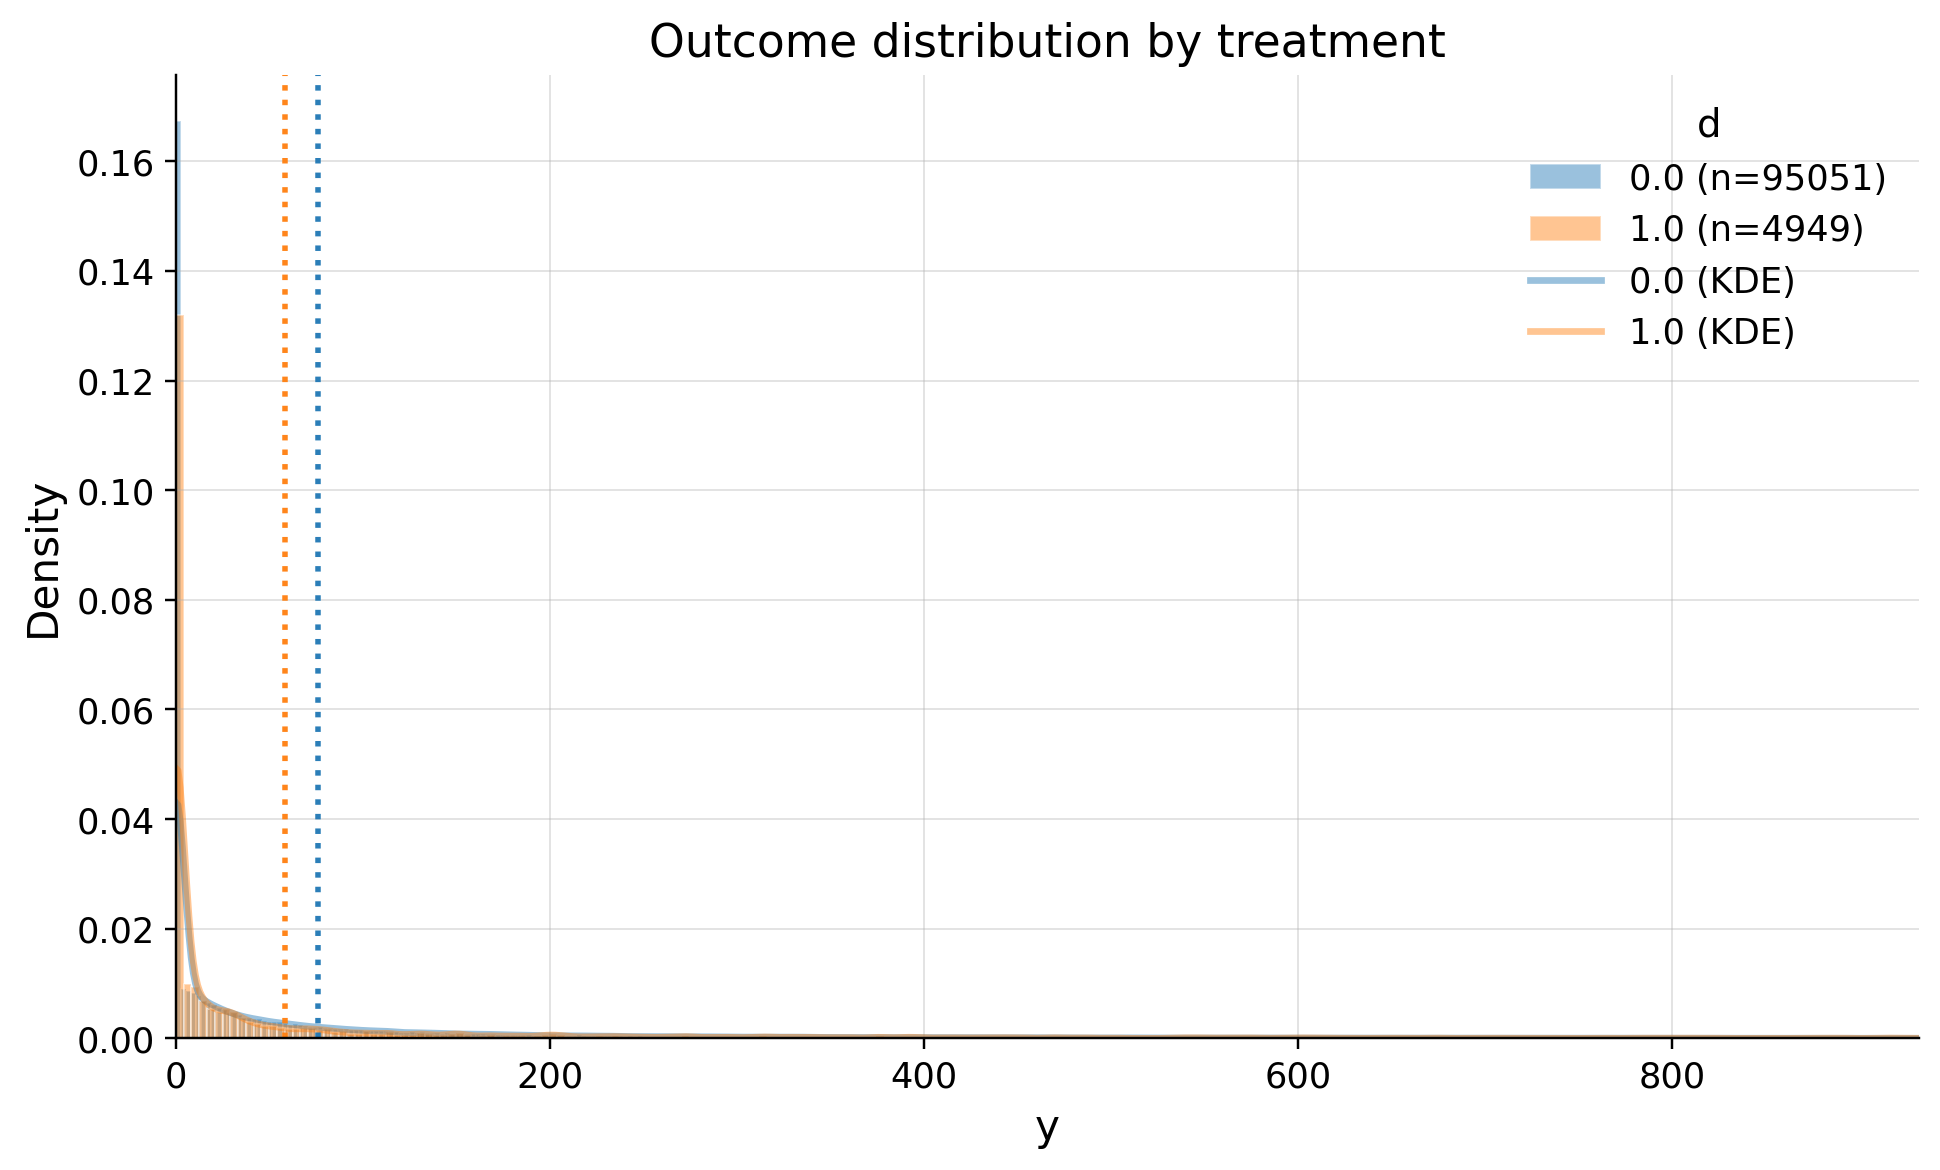

In [5]:
from causalis.shared import outcome_plot_dist, outcome_plot_boxplot
outcome_plot_dist(causaldata)

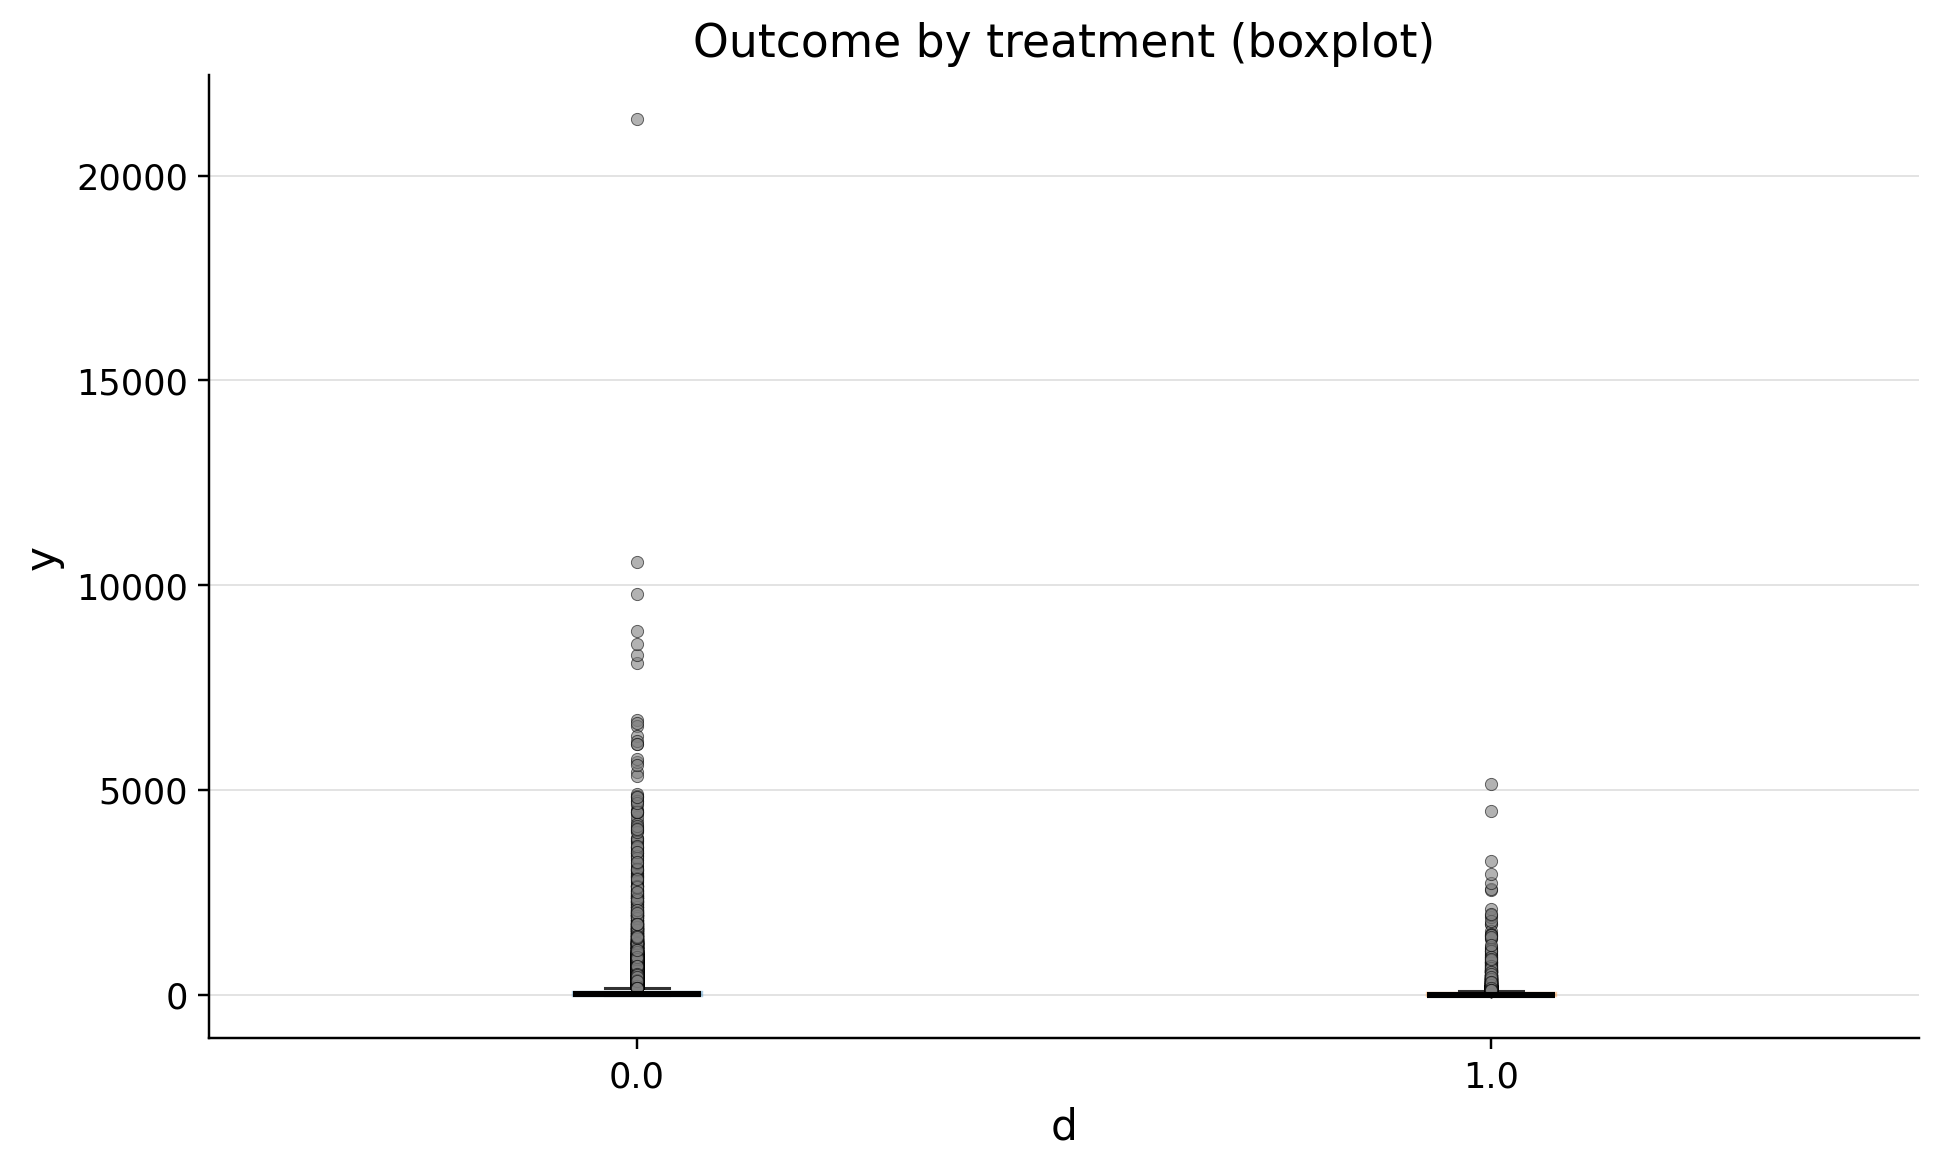

In [6]:
from causalis.shared import outcome_plot_boxplot
outcome_plot_boxplot(causaldata)

In [7]:
from causalis.shared import outcome_outliers
outcome_outliers(causaldata)

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,0.0,95051,11300,0.118884,-97.288916,162.148194,True,iqr,both
1,1.0,4949,721,0.145686,-55.437420,92.395699,True,iqr,both


In [8]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,premium_user,0.751807,0.591837,0.159970,-0.345721,0.00000
1,income_monthly,4549.385190,3918.058798,631.326392,-0.277611,0.00000
2,spend_last_month,89.091801,67.375389,21.716412,-0.268360,0.00000
3,support_tickets_90d,0.984545,1.259244,0.274699,0.253974,0.00000
4,avg_sessions_week,5.047753,4.230148,0.817606,-0.201735,0.00000
5,prior_purchases_12m,3.904220,3.513639,0.390581,-0.189372,0.00000
6,tenure_months,28.740100,25.559161,3.180939,-0.184156,0.00000
7,age_years,36.435984,34.809083,1.626901,-0.144142,0.00000
8,referred_user,0.271486,0.307133,0.035647,0.078671,0.00001
9,urban_resident,0.600793,0.568802,0.031991,-0.064954,0.00013
